In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#plt.style.use('fivethirtyeight')
import xgboost as xgb
import sklearn
import random
from NecessaryModules.getData import getData

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from NecessaryModules.splitData import split_data
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = '../shot_listed_dataset/CoverTypeNewNormalized.csv'
dataset=getData(filename).values.tolist()
random.shuffle(dataset)
dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
# print(dataset)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.850622  0.105556  0.150943                          0.045351   
1   0.879149  0.163889  0.188679                          0.426304   
2   0.767116  0.327778  0.320755                          0.068027   
3   0.791494  0.338889  0.226415                          0.294785   
4   0.867220  0.575000  0.584906                          0.385488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.003509                         0.631060   
1                        0.189474                         0.177358   
2                        0.038596                         0.259652   
3                       -0.077193                         0.085486   
4                        0.314035                         0.074020   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.866142        0.874016          0.548   
1       0.897638        0.866142          0.500   
2    

In [3]:
def split_data(data):
    # splitting the data
    
    msk = np.random.rand(len(data)) < 0.7
    yy = [54] #test title is 54 after suffleing the dataframe 
    train = data[msk]
    test = data[~msk]
    x_train = train[train.columns[:train.shape[1] - 1]]  # all columns except the last are x variables
    y_train = train[yy[0]].tolist()  # the last column as y variable
    x_test = test[test.columns[:test.shape[1] - 1]]
    y_test = test[yy[0]].tolist()  # the last column as y variable
    y_train = [0 if i == 7 else i for i in y_train]  # replace label 7 with 0
    y_test = [0 if i == 7 else i for i in y_test]  # replace label 7 with 0
    return x_train, y_train, x_test, y_test

# RFE implement

In [4]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]

In [5]:
estimator = SVR(kernel="linear")
model = RFE(estimator, n_features_to_select=40, step=1)
rfeTrain = model.fit(X,y)
print(rfeTrain)

compressed_dataset_X= rfeTrain.transform(X)
print(type(compressed_dataset_X))
print(len(compressed_dataset_X))
print(compressed_dataset_X)


RFE(estimator=SVR(kernel='linear'), n_features_to_select=40)
<class 'numpy.ndarray'>
19229
[[0.67712656 0.         0.         ... 0.         0.         0.        ]
 [0.59232365 1.         0.         ... 0.         0.         0.        ]
 [0.68698133 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.84802905 0.         0.         ... 1.         0.         0.        ]
 [0.66182573 0.         0.         ... 0.         0.         0.        ]
 [0.65845436 0.         0.         ... 0.         0.         0.        ]]


In [6]:
# from NecessaryModules.splitData import split_data
X_train, y_train, X_test, y_test = split_data(dataset)
print(len(X_train))

13558


In [7]:
compressed_dataset_X_train= rfeTrain.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= rfeTrain.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
13558
[[0.67712656 0.         0.         ... 0.         0.         0.        ]
 [0.59232365 1.         0.         ... 0.         0.         0.        ]
 [0.89548755 0.         0.         ... 1.         0.         0.        ]
 ...
 [0.73288382 0.         0.         ... 0.         0.         0.        ]
 [0.84802905 0.         0.         ... 1.         0.         0.        ]
 [0.66182573 0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'>
5671
[[0.68698133 0.         0.         ... 0.         0.         0.        ]
 [0.85399378 0.         0.         ... 0.         1.         0.        ]
 [0.59206432 1.         0.         ... 0.         0.         0.        ]
 ...
 [0.75389004 0.         0.         ... 0.         0.         0.        ]
 [0.72302905 0.         0.         ... 0.         0.         0.        ]
 [0.65845436 0.         0.         ... 0.         0.         0.        ]]


# tune with random-forest

In [8]:
# train the model with random parameter
from sklearn.ensemble import RandomForestClassifier
# Preparing the regressor and fitting data with some parameters
model = RandomForestClassifier(

    criterion="entropy",
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=25,
    n_estimators=348,
) 

model.fit(compressed_dataset_X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=348)

In [9]:
# Finding mean absolute error
preds = model.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.693881149709046

In [10]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(compressed_dataset_X)
target_train_tunned = np.array(y)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(compressed_dataset_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            'n_estimators':trial.suggest_int('n_estimators',50,500),
            'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
            'max_depth':trial.suggest_int('max_depth',20,50),
            'min_samples_split':2,
            'min_samples_leaf':1,
            'max_features':trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'random_state':trial.suggest_int('random_state',0,10),
       
      
        }
    model = RandomForestClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [11]:
# this is the main optuna for optimizing a object-->"objective"
study = optuna.create_study(direction='minimize',study_name="RF_tune")

[I 2024-02-19 18:23:08,852] A new study created in memory with name: RF_tune


In [12]:

study.optimize(objective, n_trials=10) 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-19 18:23:15,189] Trial 0 finished with value: 0.9407145457382079 and parameters: {'n_estimators': 65, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'random_state': 4}. Best is trial 0 with value: 0.9407145457382079.


19229


[I 2024-02-19 18:23:24,853] Trial 1 finished with value: 0.8719642207083051 and parameters: {'n_estimators': 91, 'criterion': 'entropy', 'max_depth': 21, 'max_features': 'sqrt', 'random_state': 9}. Best is trial 1 with value: 0.8719642207083051.


19229


[I 2024-02-19 18:23:45,780] Trial 2 finished with value: 0.92901346923917 and parameters: {'n_estimators': 137, 'criterion': 'gini', 'max_depth': 37, 'max_features': None, 'random_state': 2}. Best is trial 1 with value: 0.8719642207083051.


19229


[I 2024-02-19 18:24:24,804] Trial 3 finished with value: 0.8711841489417026 and parameters: {'n_estimators': 493, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 3 with value: 0.8711841489417026.


19229


[I 2024-02-19 18:24:49,261] Trial 4 finished with value: 0.925009100837277 and parameters: {'n_estimators': 217, 'criterion': 'entropy', 'max_depth': 35, 'max_features': 'log2', 'random_state': 9}. Best is trial 3 with value: 0.8711841489417026.


19229


[I 2024-02-19 18:25:33,857] Trial 5 finished with value: 0.927453325705965 and parameters: {'n_estimators': 252, 'criterion': 'entropy', 'max_depth': 32, 'max_features': None, 'random_state': 5}. Best is trial 3 with value: 0.8711841489417026.


19229


[I 2024-02-19 18:25:39,664] Trial 6 finished with value: 0.8914660148733683 and parameters: {'n_estimators': 56, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'log2', 'random_state': 7}. Best is trial 3 with value: 0.8711841489417026.


19229


[I 2024-02-19 18:26:05,378] Trial 7 finished with value: 0.9281293879036872 and parameters: {'n_estimators': 277, 'criterion': 'gini', 'max_depth': 49, 'max_features': 'log2', 'random_state': 3}. Best is trial 3 with value: 0.8711841489417026.


19229


[I 2024-02-19 18:26:55,875] Trial 8 finished with value: 0.9116958760205939 and parameters: {'n_estimators': 451, 'criterion': 'log_loss', 'max_depth': 32, 'max_features': 'log2', 'random_state': 1}. Best is trial 3 with value: 0.8711841489417026.


19229


[I 2024-02-19 18:27:32,946] Trial 9 finished with value: 0.932705808934422 and parameters: {'n_estimators': 326, 'criterion': 'log_loss', 'max_depth': 40, 'max_features': 'log2', 'random_state': 4}. Best is trial 3 with value: 0.8711841489417026.


19229
Number of finished trials: 10
Best trial: {'n_estimators': 493, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'sqrt', 'random_state': 8}


In [13]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value:  0.8711841489417026
  Params: 
    n_estimators: 493
    criterion: gini
    max_depth: 22
    max_features: sqrt
    random_state: 8


# process the whole dataset

In [14]:
filename_2 = '../shot_listed_dataset/Cover_type_whole_genuine_dataset_normalization.csv'
dataset_2=getData(filename_2).values.tolist()
random.shuffle(dataset_2)

dataset_2=pd.DataFrame(dataset_2) #from dataset_list to dataset_dataframe after suffling
print(dataset_2)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.672888  0.141667  0.045455                          0.184681   
1   0.671332  0.155556  0.030303                          0.151754   
2   0.726801  0.386111  0.136364                          0.191840   
3   0.721877  0.430556  0.272727                          0.173228   
4   0.672628  0.125000  0.030303                          0.109520   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.000000                         0.071659   
1                       -0.009983                         0.054798   
2                        0.108153                         0.446817   
3                        0.196339                         0.434172   
4                       -0.001664                         0.054939   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.870079        0.913386       0.582677   
1       0.866142        0.925197       0.594488   
2    

In [15]:
# checking for NaN value
result = dataset_2.columns[dataset_2.isna().any()].tolist()
result

[]

In [16]:
X_2=dataset_2.iloc[:,0:-1]
y_2=dataset_2.iloc[:,-1]
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(dataset_2)

In [17]:
# pcaTrain_2 = PCA(n_components=30).fit(X_2)# --train-- pca with the "dataset" Dataframe
# print(pcaTrain_2)
compressed_dataset_X_2 = rfeTrain.transform(X_2) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters


compressed_dataset_X_train_2= rfeTrain.transform(X_train_2) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train_2))
print(len(compressed_dataset_X_train_2))


compressed_dataset_X_test_2= rfeTrain.transform(X_test_2) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test_2))
print(len(compressed_dataset_X_test_2))


<class 'numpy.ndarray'>
407004
<class 'numpy.ndarray'>
174008


# fit the R-F

In [18]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [19]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(compressed_dataset_X_train_2)
target_train = np.array(y_train_2)

test = np.array(compressed_dataset_X_test_2)
# target_train = df_train['congestion'].values

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(compressed_dataset_X_train_2), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    rf_params = study.best_trial.params
    model = RandomForestClassifier(**rf_params)
    model.fit(train_X, train_y)
    # for train accuracy
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [20:39<00:00, 247.91s/it]

0.3916251437332311


In [20]:
target_test = np.array(y_test_2)
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)

# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds.round())
print(test_Acc_SVC)

0.7042319893338237


In [21]:
valid_Acc=accuracy_score(target_train,oof_preds)
print(valid_Acc)

0.7109733565272086


In [22]:
train_Acc=model.score(compressed_dataset_X_train_2,y_train_2)
print(train_Acc)

0.7217349215241128


In [23]:
test_Acc=model.score(compressed_dataset_X_test_2,y_test_2)
print(test_Acc)

0.7104500942485403


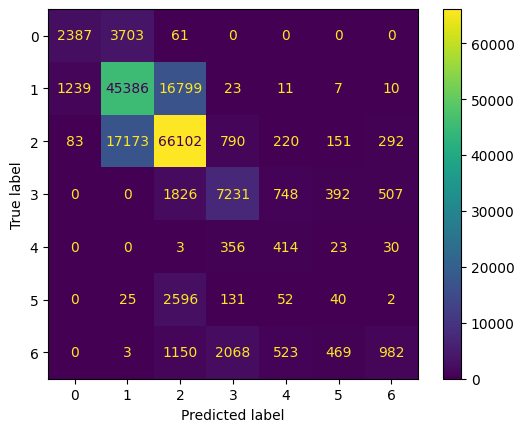

In [24]:
############# plot confusion matrix ############

from sklearn import metrics

cm = metrics.confusion_matrix(target_test, test_preds.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()